#Check random transform statistics 

In [4]:
import numpy as np
from scipy.stats import mvn
from scipy.fftpack import dct
from scipy.integrate import quad
from scipy.stats import norm
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Basic functions

In [5]:
def dmu(t, h):
    return np.exp(-h**2/(1.+t))/(2.*np.pi*np.sqrt(1.-t**2))

def mu_of_h(t, h):
    return quad(lambda x: dmu(x, h), 0., t)[0] + (1. - norm.cdf(h))**2

def mu(m, r, lambda_):
    h = np.sqrt(2*r*np.log(m))
    mu_, _ = mvn.mvnun([-10**5, -10**5], [-h,-h], [0,0], [[1,lambda_],[lambda_,1]])
    return mu_

def val(eps, m, r, eta, lambda_,):
    mu_lambda_eps = mu(m, r, lambda_-eps)
    val_ = (mu(m, r, lambda_)-mu_lambda_eps)*np.sqrt(m)/np.sqrt(mu_lambda_eps*(1-mu_lambda_eps))/eta
    return val_
    
def eps(m, r, eta, lambda_, choice):
    h = np.sqrt(2*r*np.log(m))
    
    if choice == 1:
        C = np.sqrt(2*np.pi*(1+lambda_)**2*np.sqrt(1-lambda_**2))*eta/h
        eps_ = C*np.exp(h**2/(2*(1+lambda_)))/np.sqrt(m)
        
    elif choice ==2:
        actual_deriv = 1/(2*np.pi*np.sqrt(1-lambda_**2))*np.exp(-h**2/(1+lambda_))
        mu_ = mu(m, r, lambda_)
        eps_ = eta*np.sqrt(mu_*(1-mu_))/actual_deriv/np.sqrt(m)
        
    elif choice ==3:
        tol = 10**-6
        eps_ = eps(m, r, eta, lambda_, 2)
        max_, min_ = eps_*4, eps_/4
        error = 2*tol
        
        while error > tol:
            current_val = val(eps_, m, r, eta, lambda_)
            if current_val > 1:
                max_ = eps_
            else:
                min_ = eps_
            error = abs(current_val-1)
            eps_ = (max_+min_)/2
            
    return eps_

In [6]:
def gen_xy(lambda_, d, random_state):
    ''' generate an x and y for testing transforms
    '''
    B = random_state.randn(d, 2)
    U,s,V = np.linalg.svd(B)
    x1, x2 = U[:,0], U[:,1]
    y = lambda_*x1+(np.sqrt(1-lambda_**2))*x2
    return x1, y

In [7]:
from scipy.optimize import brentq

def f_of_epsilon_minus(eps_minus, m, r, eta, lambda_):
    ''' objective to solve for non-asymptotic eps^- in (3.8)
        of paper
    '''
    mu_lambda = mu(m, r, lambda_)
    mu_lambda_eps = mu(m, r, lambda_-eps_minus)
    sigma = np.sqrt(mu_lambda_eps*(1.-mu_lambda_eps))    
    return np.sqrt(m)*(mu_lambda - mu_lambda_eps)/sigma - eta

def f_of_epsilon_plus(eps_plus, m, r, eta, lambda_):
    ''' objective to solve for non-asymptotic eps^+ in (3.8)
        of paper
    '''
    mu_lambda = mu(m, r, lambda_)
    mu_lambda_eps = mu(m, r, lambda_+eps_plus)
    sigma = np.sqrt(mu_lambda_eps*(1.-mu_lambda_eps))    
    return np.sqrt(m)*(mu_lambda - mu_lambda_eps)/sigma + eta

def epsilon_minus(m, r, eta, lambda_):
    try:
        return -brentq(f_of_epsilon_minus, a=0.0, b=1.0, args=(m, r, eta, lambda_,))
    except ValueError:
        return -lambda_
    
def epsilon_plus(m, r, eta, lambda_):
    try:
        return brentq(f_of_epsilon_plus, a=0.0, b=1.0, args=(m, r, eta, lambda_,))
    except ValueError:
        return 1.0-lambda_

## Print and display

In [8]:
sns.set(style="darkgrid")
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})

In [9]:
def format_error(x, dx, precision=3):
    ''' print 2.34296e-7 \pm 6.3123e-8 as
        (2.342+/-0.631)e-7
    '''
    
    x_exponent = 0 if x==0 else int(math.floor(math.log10(x*x)/2))
    x /= 10**x_exponent
    dx /= 10**x_exponent
    return u'{1:.{0}f}\u00b1{2:.{0}f}e{3:d}'.format(precision, x, dx, x_exponent)
    
def print_stats(x):
    print(u"mean/std: {}".format(format_error(x.mean(), x.std())))
    print(u"median/iqr: {}".format(format_error(np.median(x), 0.5*(np.percentile(x, 84)-np.percentile(x, 16)))))

## Define transforms

In [10]:
class RandomTransformer(object):
    def __init__(self, d, m, r, random_state):
        self.random_state = random_state
        self.h = np.sqrt(2.*r*np.log(m))
        self.d = d
        self.m = m
        
    def transform(self, x):
        raise NotImplemented
    
    def threshold(self, x):
        return self.transform(x)>self.h
    
    def sparse(self, x):
        return set(np.nonzero(self.threshold(x))[0])
    
    def dense(self, x, dtype=int):
        return np.array(self.threshold(x), dtype=dtype)
    
    def score(self, x, y):
        return np.sum(np.logical_and(self.dense(x, dtype=bool), self.dense(y, dtype=bool)))/float(self.m)
    
class GaussianTransformer(RandomTransformer):
    name = "Gaussian"
    
    def __init__(self, d, m, r, random_state):
        super(GaussianTransformer, self).__init__(d, m, r, random_state)
        self.A = self.random_state.normal(size=(m, d))
        
    def transform(self, x):
        return np.dot(self.A, x)
    
class StructuredTransformer(RandomTransformer):
    name = "Structured"
    
    def __init__(self, d, m, r, random_state):
        super(StructuredTransformer, self).__init__(d, m, r, random_state)
        self.choices = self.random_state.choice(m, size=d, replace=False)
        self.signs = 1.0-2.0*self.random_state.randint(2, size=d)
        self.y = np.zeros(m)
        
    def transform(self, x):
        self.y[self.choices] = x*self.signs
        return dct(self.y, type=2, norm='ortho')*np.sqrt(self.m)
    
class BlockStructuredTransformer(RandomTransformer):
    name = "Block Structured"
    
    def __init__(self, d, m, r, random_state):
        assert not m%d, "BlockStructuredTransformer: m must be a multiple of d"
        super(BlockStructuredTransformer, self).__init__(d, m, r, random_state)
        
        # random sign changes: each row will apply a random set of sign changes to input x
        self.signs = 1.0-2.0*self.random_state.randint(2, size=(m/d, d))
        
    def transform(self, x):
        # use np.multiply's broadcasting to apply each row of sign changes to input x
        return dct(np.multiply(self.signs, x).flatten(), type=2, norm='ortho')*np.sqrt(self.d)
    
class RandomSignTransformer(RandomTransformer):
    name = "Random Sign"
    comment = "no this doesn't work: seemed too good to be true"
    
    def __init__(self, d, m, r, random_state):
        assert not m%d, "RandomSignTransformer: m must be a multiple of d"
        super(RandomSignTransformer, self).__init__(d, m, r, random_state)
        
        # random sign changes: each row will apply a random set of sign changes to input x
        self.signs = 1.0-2.0*self.random_state.randint(2, size=(m/d, d))
        
    def transform(self, x):
        # use np.multiply's broadcasting to apply each row of sign changes to input x
        return np.multiply(self.signs, x).flatten()*np.sqrt(self.d)

## Basic transformer tests

In [11]:
def test_transformer(transformer_type):
    random_state = np.random.RandomState(42)
    
    d = 100
    m = 100000
    r = 0.4
    nb_trials = 100

    if transformer_type==GaussianTransformer:
        d = 2
    
    # create a random vector with unit norm
    x = np.random.randn(d)
    x /= np.linalg.norm(x)

    results = np.zeros(nb_trials, dtype=float)
    for k, _ in enumerate(results):
        # transform the vector and measure the norm of the transformed vector
        transformer = transformer_type(d, m, r, random_state)
        results[k] = np.linalg.norm(transformer.transform(x))
    print_stats(results)

In [12]:
test_transformer(GaussianTransformer)

mean/std: 3.162±0.007e2
median/iqr: 3.161±0.006e2


In [13]:
test_transformer(StructuredTransformer)

mean/std: 3.162±0.000e2
median/iqr: 3.162±0.000e2


In [14]:
test_transformer(BlockStructuredTransformer)

mean/std: 3.162±0.000e2
median/iqr: 3.162±0.000e2


In [15]:
test_transformer(RandomSignTransformer)

mean/std: 3.162±0.000e2
median/iqr: 3.162±0.000e2


In [40]:
def test_score(transformer_type):
    random_state = np.random.RandomState(42)
    
    d = 200
    m = 100000
    r = 0.4
    lambda_ = 0.9
    nb_trials = 100

    if transformer_type==GaussianTransformer:
        d = 2
    
    # create a random vector with unit norm
    x, y = gen_xy(lambda_, d, random_state)

    results = np.zeros(nb_trials, dtype=float)
    for k, _ in enumerate(results):
        # transform the vector and measure the norm of the transformed vector
        transformer = transformer_type(d, m, r, random_state)
        results[k] = transformer.score(x, y)
        
    print_stats(results)

In [41]:
test_score(GaussianTransformer)

mean/std: 5.290±0.686e-4
median/iqr: 5.300±0.700e-4


In [42]:
test_score(StructuredTransformer)

mean/std: 5.003±0.755e-4
median/iqr: 4.900±0.808e-4


In [43]:
test_score(BlockStructuredTransformer)

mean/std: 5.355±0.724e-4
median/iqr: 5.400±0.658e-4


In [44]:
test_score(RandomSignTransformer)

mean/std: 0.000±0.000e0
median/iqr: 0.000±0.000e0


## Error rate tests

In [25]:
def compute_error(lambda_, eta_, d_, m_, r_, transform_type, nb_iters, error_type, random_state):
    ''' compute the error rate
    '''
    assert(error_type=='Type I' or error_type=='Type II')
    
    epsilon_function = (epsilon_minus if error_type=='Type I' else epsilon_plus)
    epsilon = epsilon_function(m_, r_, eta_, lambda_)
        
    x, y = gen_xy(lambda_+epsilon, d_, random_state)
    threshold_ = mu(m_, r_, lambda_)
    
    nb_errors = 0
    for i in range(nb_iters):
        score_ = transform_type(d_, m_, r_, random_state).score(x, y)
        nb_errors += (score_ > threshold_ if error_type=='Type I' else score_ < threshold_)

    return nb_errors/float(nb_iters)

In [45]:
def plot_error(transform_type, error_type, random_state=np.random.RandomState(42)):

    lambda_=0.9
    eta = np.arange(0, 3, 0.1)
    r = [0.2, 0.4, 0.6]
    m = 10**5
    d = 100
    nb_iters = 3000

    # larger d not necessary for Gaussian Transformer
    if transform_type == GaussianTransformer:
        d = 2
    
    plt.rc('font', family='serif', size=16)
    fig,ax = plt.subplots(figsize=(12, 6))
    ax.set_xlabel(r'Eta: $\eta$', fontsize=16)
    ax.set_ylabel(r'{} error'.format(error_type), fontsize=16)
    ax.set_title(r'{}: $m = {}$, $d = {}$, $\lambda = {}$'.format(transform_type.name, m, d, lambda_), fontsize=18)

    alphas = []

    for k, r_ in enumerate(r):
        alphas.append([
                compute_error(lambda_, eta_, d, m, r_, transform_type, nb_iters, 
                              error_type, random_state) for eta_ in eta])
        ax.plot(eta, alphas[k], '-', label="$r = {}$".format(r_))  
    ax.plot(eta, norm.sf(eta), '--', label= r"$theory$") 
    ax.legend()

    plt.show()
    
    return eta, alphas

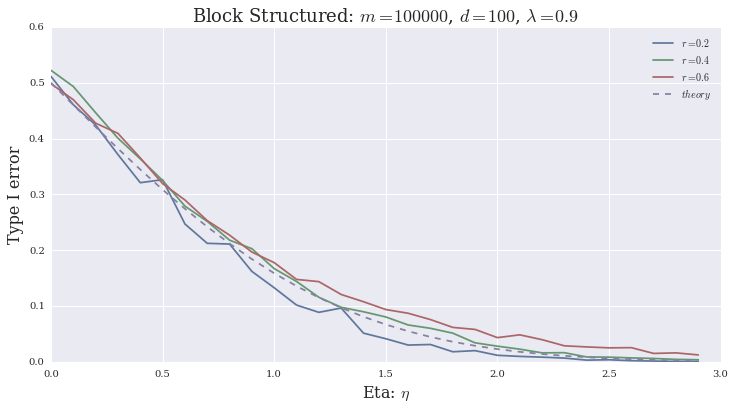

In [46]:
eta, alphas = plot_error(BlockStructuredTransformer, 'Type I', np.random.RandomState(0))

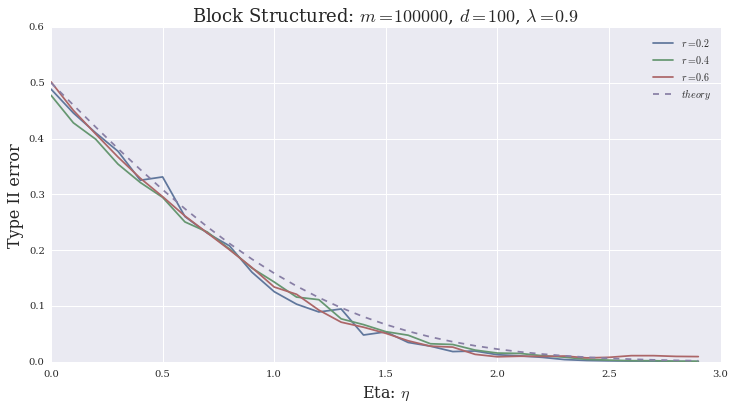

In [47]:
eta, alphas = plot_error(BlockStructuredTransformer, 'Type II', np.random.RandomState(0))

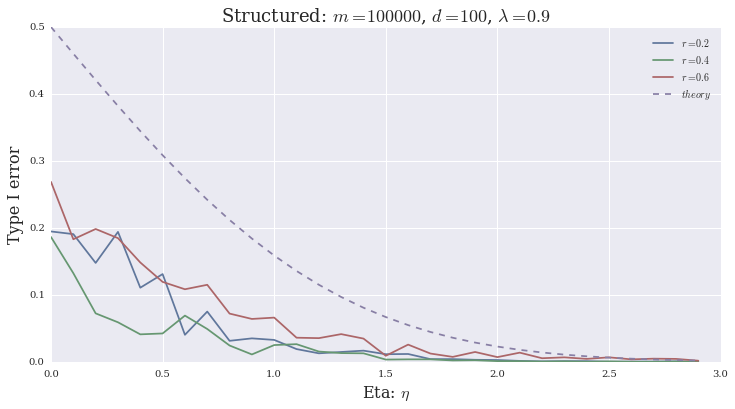

In [48]:
eta, alphas = plot_error(StructuredTransformer, 'Type I', np.random.RandomState(0))

In [49]:
eta, alphas = plot_error(StructuredTransformer, 'Type II', np.random.RandomState(0))

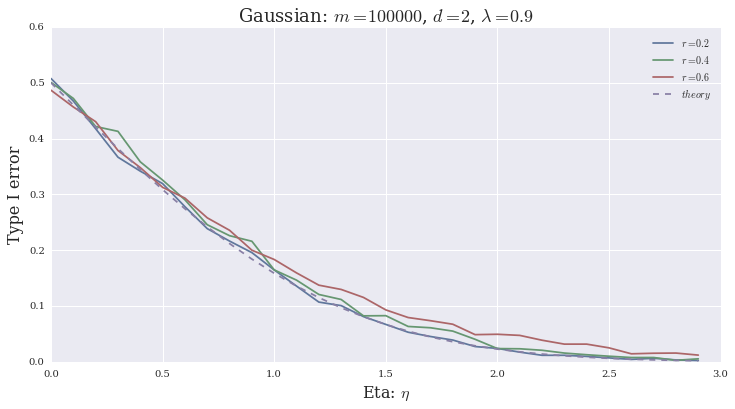

In [50]:
eta, alphas = plot_error(GaussianTransformer, 'Type I', np.random.RandomState(0))

In [51]:
eta, alphas = plot_error(GaussianTransformer, 'Type II', np.random.RandomState(0))

## Sparsity Simulations

In [16]:
def compute_sparsity(transformer_type, d_, m_, r_, nb_iters):
    lens_summed = 0
    for j in range(0,nb_iters):
        x = np.random.randn(d_)
        x = x/float(np.linalg.norm(x))
        sparsity = transformer_type(d_, m_, r_, np.random.RandomState(42)).sparse(x)
        lens_summed += len(sparsity)
    return lens_summed/float(nb_iters)

In [17]:
def plot_sparsity(transformer_type):
    plt.rc('font', family='serif', size=16)
    fig,ax = plt.subplots(figsize=(12, 6))
    ax.set_xlabel(r'vocabulary size: $m$', fontsize=16)
    ax.set_ylabel(r'sparsity: $\bar{k}$', fontsize=16)
    ax.set_title(r'Sparsity: d = 100', fontsize = 18)
    
    r = [0.2,0.4,0.6]
    m = np.logspace(2,6,10)
    if transformer_type == BlockStructuredTransformer: 
        #m must be a multiple of d
        m = [100, 5*100, 10**3, 5*10**3, 10**4, 5*10**4, 10**5, 5*10**5, 10**6]
    d = 100
    nb_iters = 10

    f_k_bars = [[],[],[]]
    for i, r_ in enumerate(r):
        f_k_bars[i] = [compute_sparsity(transformer_type, d, int(m_), r_, nb_iters) for m_ in m]
        ax.loglog(m, f_k_bars[i], '-', label="$r = {}$".format(r_))
    ax.legend(loc = 'upper left') 
    plt.show()

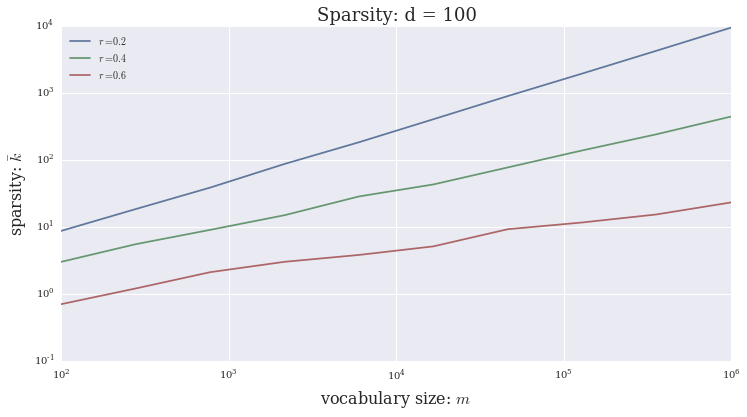

In [18]:
plot_sparsity(GaussianTransformer)

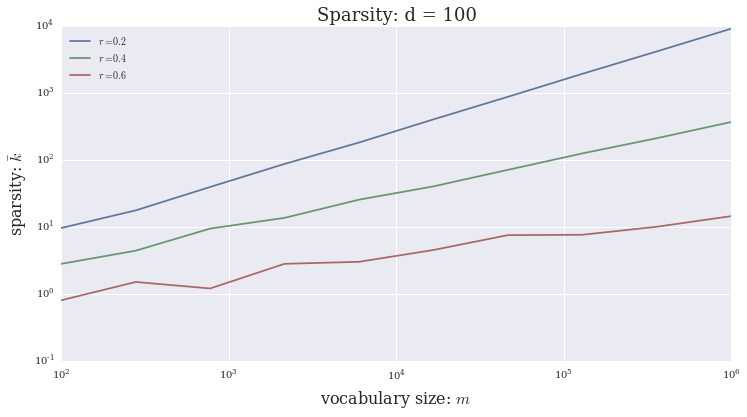

In [19]:
plot_sparsity(StructuredTransformer)

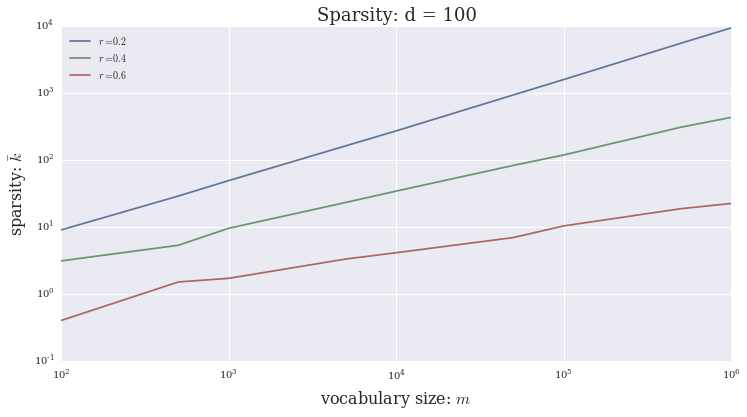

In [20]:
plot_sparsity(BlockStructuredTransformer)